In [ ]:
## Importing Libraries

In [1]:
import numpy as np
import math
import time
import pymongo
import pandas as pd
import concurrent.futures
import matplotlib.pyplot as plt
import statistics
import numpy as np


In [ ]:
## Connecting to Mongo and collecting Data of individual stocks

In [2]:
client = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
mydb = client['Algorithmic_Trading']
info = mydb.historical_data_500

symbols = []
for i in info.find():
    symbols.append(i['Symbol'])
all_closes = {}
for s in symbols:
    for i in info.find({"Symbol" : s}):
        cl = []
        for x in i["Data"]:
            cl.append(x["Close"])
    all_closes[s] = cl
            

    



In [ ]:
## Implementing KAMA indicator

In [4]:
def kaufman(n,stock,fast,slow):
    
   
    def rolling_diff(t,n):
        x = []
        for i in range(n,len(t)):
            x.append(abs(t[i]-t[i-n]))
        return x
    
    def rolling_sum(t,n):
        x = []
        for i in range(0,len(t)-n+1):
            x.append(sum(t[i:i+n]))
        return x
    def rolling_mean(t,n):
        x = []
        for i in range(0,len(t) - n + 1):
            x.append(sum(t[i:i+n])/n)
        return x
    
    fastest = (2/(fast+1))
    slowest = (2/(slow+1))
    
    close = all_closes[stock]

    used_closes = close[n:]


    one_day_diff = rolling_diff(close,1)[n-1:]
    fourteen_day_diff = rolling_diff(close,n)
    total_dist = rolling_sum(rolling_diff(close,1),n)
    eff = []


    for i in range(0,len(total_dist)):
        if total_dist[i] != 0:
            eff.append(fourteen_day_diff[i]/total_dist[i])
        else:
            eff.append(0)
    starting_mean = rolling_mean(close,n)[0]

    kama = []

    for i in range(0,len(total_dist)):
        sc = ((eff[i]*(fastest - slowest))  + slowest)**2
        new_kama  = starting_mean + (sc*(used_closes[i] - starting_mean))
        kama.append(new_kama)
        starting_mean = new_kama
  
    return kama


    
    




In [ ]:
## Backtesting the strategy on particular stocks

In [5]:
counting_days = 14
stock = 'IOLCP'

kama = kaufman(counting_days,stock,2,30)
closes = all_closes[stock][counting_days:]

dates = []
for i in info.find({"Symbol" : stock}):
    for dd in i['Data']:
        dates.append(dd['Date'])
dates
f_dates = dates[counting_days:]

profit = 0
total = 0
invested = 0
i = 0



while i < len(closes)-1:
    if closes[i]<(1.03*kama[i]) and closes[i] > kama[i]:
        
        profit = 0
        
        buy_price = 1.01*kama[i]
        
        
        if(buy_price > invested):
            invested = buy_price
        
        j = i
        

        
        
        while closes[j] >(0.99*kama[j]) and j < len(closes)-1:
            j = j+1
        sell_price = 0.99*kama[j]
        

        
        
        profit = sell_price - buy_price
        
        total = total + profit
       
        
      
       
        i=i+1
    
    elif closes[i]>(0.97*kama[i]) and closes[i]<kama[i]:
        profit = 0
        
        sell_price = 0.99*kama[i]
        
        
        
        
        j = i
        
        
        while closes[j] <(1.01*kama[j]) and j < len(closes)-1:
            j = j+1
        buy_price = 1.01*kama[j]
        
        
        
        profit = sell_price - buy_price
        
        total = total + profit
      
        
        
   
        i= i+1
    else:
        i = i+1
        
    
print("p/l--",total)



p/l-- 5353.791839565076


In [ ]:
##Filtering stocks based on distance of closing price to KAMA

In [6]:
filtered = []
start_time = time.time()
for s in symbols:
    kaufman_adap = kaufman(14,s,2,30)
    this_close = all_closes[s]
    
    if this_close[-1] > kaufman_adap[-1] and this_close[-1] < (1.01 * kaufman_adap[-1]):
        filtered.append(s)
        


--- 3.0341219902038574 seconds ---


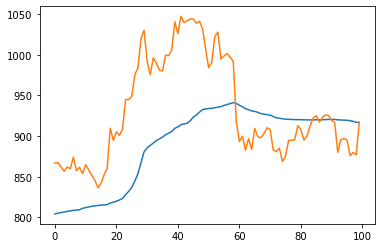

In [22]:
counting_days = 14
stock = 'CUMMINSIND'
k = kaufman(counting_days,stock,5,30)
cl = all_closes[stock][counting_days:]
plt.plot(k[-100:])
plt.plot(cl[-100:])